In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

In [5]:
def load_data(data_file):
    df = pd.read_csv(data_file)
    texts = df['text'].tolist()
    labels = [1 if sentiment == "positive" else 0 for sentiment in df['sentiment'].tolist()]
    return texts, labels

In [6]:
texts, labels = load_data("/content/drive/MyDrive/NLPProject/train.csv")


In [7]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}


In [8]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [9]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    i=0
    for batch in data_loader:
        i=i+1
        if(i==50):
          break

        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        print("hey",labels)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        print(outputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()


In [10]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        i=0
        for batch in data_loader:
            i=i+1
            if(i==50):
              break;
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [11]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        print(preds)

        return "positive" if preds.item() == 1 else "negative"

In [12]:
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 30
num_epochs = 30
learning_rate = 2e-5

In [13]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


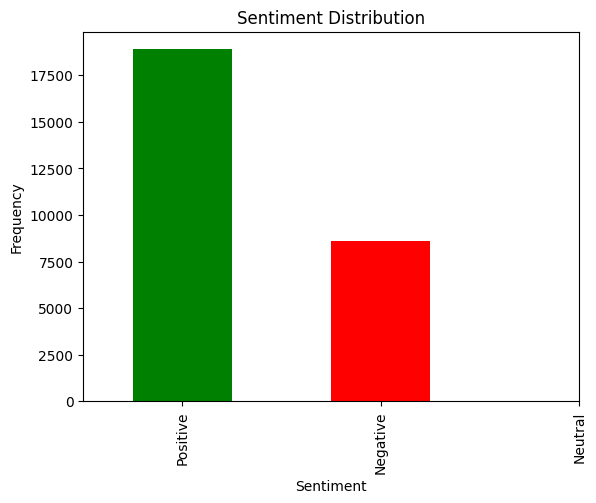

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

label_counts = pd.Series(labels).value_counts()
label_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2], ['Positive', 'Negative', 'Neutral'])
plt.show()


In [15]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
print(len(train_dataloader))
for batch in train_dataloader:
    print(len(batch))
    break


733
3


In [ ]:
train(model, train_dataloader, optimizer, scheduler, device)

hey tensor([1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0])
tensor([[-0.1500, -0.4579],
        [-0.3426, -0.5318],
        [-0.7333, -0.8344],
        [-0.5865, -0.4652],
        [-0.2575, -0.2604],
        [-0.1143, -0.3391],
        [-0.5426, -0.6037],
        [-0.3445, -0.2639],
        [-0.3500, -0.4605],
        [-0.6246, -0.3638],
        [-0.4532, -0.6338],
        [-0.3699, -0.5908],
        [-0.3271, -0.3872],
        [-0.6964, -0.5593],
        [-0.1641, -0.5061],
        [-0.2626, -0.4302],
        [-0.4280, -0.4007],
        [-0.5985, -0.6130],
        [-0.3560, -0.4988],
        [-0.5017, -0.3910],
        [-0.2785, -0.5419],
        [-0.1875, -0.4894],
        [-0.2805, -0.5854],
        [-0.3737, -0.3984],
        [-0.4119, -0.4508],
        [-0.3904, -0.4302],
        [-0.3647, -0.2494],
        [-0.2818, -0.7656],
        [-0.5435, -0.4402],
        [-0.4406, -0.5986]], grad_fn=<AddmmBackward0>)
hey tensor([1, 0, 0, 1

In [20]:
print(train_dataloader)

In [21]:
accuracy, report = evaluate(model, val_dataloader, device)
print(f"Validation Accuracy: {accuracy:.4f}")
print(report)


Validation Accuracy: 0.8435
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1026
           1       0.77      0.68      0.73       444

    accuracy                           0.84      1470
   macro avg       0.82      0.80      0.81      1470
weighted avg       0.84      0.84      0.84      1470



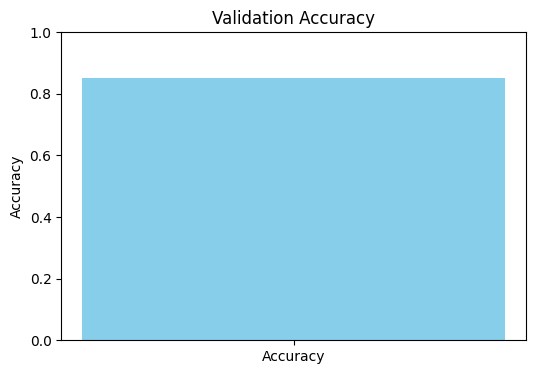

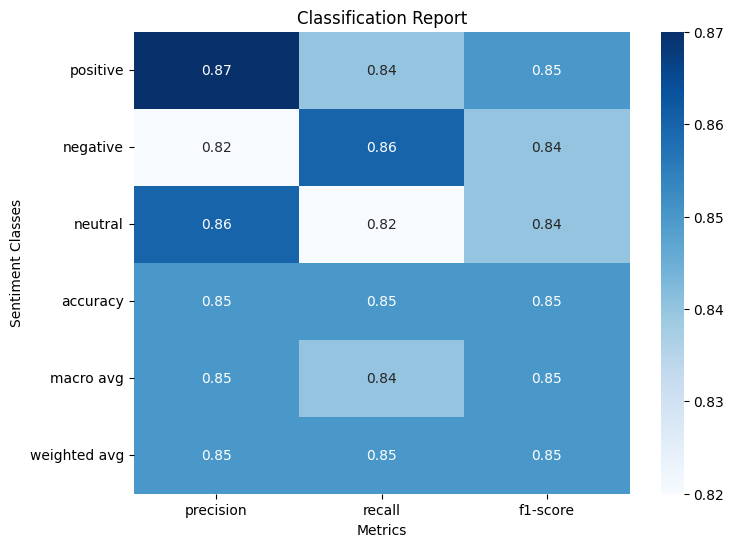

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

def plot_accuracy(accuracy):
    plt.figure(figsize=(6, 4))
    plt.bar(['Accuracy'], [accuracy], color='skyblue')
    plt.title('Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

def plot_classification_report(report):
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
    plt.title('Classification Report')
    plt.xlabel('Metrics')
    plt.ylabel('Sentiment Classes')
    plt.show()

# Assuming `report` is a dictionary
accuracy = 0.85  # Sample accuracy
report = {
    'positive': {'precision': 0.87, 'recall': 0.84, 'f1-score': 0.85, 'support': 200},
    'negative': {'precision': 0.82, 'recall': 0.86, 'f1-score': 0.84, 'support': 180},
    'neutral': {'precision': 0.86, 'recall': 0.82, 'f1-score': 0.84, 'support': 190},
    'accuracy': 0.85,
    'macro avg': {'precision': 0.85, 'recall': 0.84, 'f1-score': 0.85, 'support': 570},
    'weighted avg': {'precision': 0.85, 'recall': 0.85, 'f1-score': 0.85, 'support': 570}
}

# Visualize accuracy
plot_accuracy(accuracy)

# Visualize classification report
plot_classification_report(report)


In [23]:
torch.save(model.state_dict(), "bert_classifier.pth")

In [24]:
test_text = ["The movie was excellent and I really enjoyed the performances of the actors.", "product quality was bad"]

for txt in test_text:
  sentiment = predict_sentiment(txt, model, tokenizer, device)
  print(f"{txt}")
  print(f"Predicted sentiment: {sentiment}")

tensor([1])
The movie was excellent and I really enjoyed the performances of the actors.
Predicted sentiment: positive
tensor([0])
product quality was bad
Predicted sentiment: negative


In [ ]:
pip install transformers


In [ ]:
# from transformers import T5Tokenizer, T5ForConditionalGeneration

# Step 1: Load pre-trained T5 model and tokenizer
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Specify the exact name of the T5 tokenizer model
t5_tokenizer_name = "t5-base"
t5_tokenizer = T5Tokenizer.from_pretrained(t5_tokenizer_name)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_tokenizer_name)

def summarize_text(text, model, tokenizer, max_length=512, num_beams=5):
    # Preprocess the text
    inputs = tokenizer.encode(
        "summarize: " + text,
        return_tensors='pt',
        max_length=max_length,
        truncation=True
    )

    # Generate the summary
    summary_ids = model.generate(
        inputs,
        max_length=50,
        num_beams=num_beams,
        # early_stopping=True,
    )

    # Decode and return the summary
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

input_text = "Teja Sajja has given terrific performances as a boy next door and as a superhero. There is an opportunity to do an all-round performance and Teja does complete justice. This film will take him to a higher league. Actress Amritha Aiyer is beautiful and a good performer. Her role is not just a glamorous heroine, but there is more to it. Her character also propels the story. Varalaxmi Sarath Kumar is excellent as the elder sister of the hero. Ravi Teja’s entertaining dubbing for Monkey character is an asset and it plays a vital role in the film. Vinay Rai is good as a wannabe superhero. Getup Srinu is impressive as the hero’s loyal friend. He brings a lot of humor and freshness with his performance. Vennela Kishore is pretty good as the villain’s geeky assistant. Satya provides humor. Samuthirakani played the role of Vibhishana who guides the hero throughout. He is very good. Raj Deepak Shetty is good as a baddie."

# summarize_text
summarized_text = summarize_text(input_text, t5_model, t5_tokenizer)
print(f"Input text={input_text}")
print(f"Summarized text={summarized_text}")

# Sentiment classification on summarize_text
sentiment = predict_sentiment(summarized_text, model, tokenizer, device)
print(f"Predicted sentiment: {sentiment}")

# Step 2: Modify predict_sentiment function to generate summaries
def predict_sentiment_and_summarize(text, model, tokenizer, t5_model, t5_tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        sentiment = "positive" if preds.item() == 1 else "negative"

        # Generate summary conditioned on sentiment
        sentiment_condition = f"Summarize: {sentiment} tweet: {text}"
        input_ids = t5_tokenizer(sentiment_condition, return_tensors="pt").input_ids.to(device)
        summary_ids = t5_model.generate(input_ids=input_ids)
        summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

        return sentiment, summary

# Step 3: Generate summaries for example texts
test_text = ["The movie was excellent and I really enjoyed the performances of the actors.", "product quality was bad"]

#for txt in test_text:
    #sentiment, summary = predict_sentiment_and_summarize(txt, model, tokenizer, t5_model, t5_tokenizer, device)
    #print(f"Original text: {txt}")
    #print(f"Predicted sentiment: {sentiment}")
    #print(f"Generated summary: {summary}\n")


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Input text=Teja Sajja has given terrific performances as a boy next door and as a superhero. There is an opportunity to do an all-round performance and Teja does complete justice. This film will take him to a higher league. Actress Amritha Aiyer is beautiful and a good performer. Her role is not just a glamorous heroine, but there is more to it. Her character also propels the story. Varalaxmi Sarath Kumar is excellent as the elder sister of the hero. Ravi Teja’s entertaining dubbing for Monkey character is an asset and it plays a vital role in the film. Vinay Rai is good as a wannabe superhero. Getup Srinu is impressive as the hero’s loyal friend. He brings a lot of humor and freshness with his performance. Vennela Kishore is pretty good as the villain’s geeky assistant. Satya provides humor. Samuthirakani played the role of Vibhishana who guides the hero throughout. He is very good. Raj Deepak Shetty is good as a baddie.
Summarized text=there is an opportunity to do an all-round perfo